In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from datetime import datetime

# yahoo Finance API library (useful?)
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

from pandas_datareader import data as pdr
yf.pdr_override()

In [39]:
stock = 'AMD'

end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

In [40]:
globals()[stock] = yf.download(stock, start, end)
df_amd = globals()[stock]

[*********************100%%**********************]  1 of 1 completed


## Data Cleaning

In [41]:
df_amd.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-03,81.970001,82.000000,78.459999,78.550003,78.550003,66323300
2021-05-04,77.949997,78.669998,77.040001,78.610001,78.610001,59194300
2021-05-05,79.050003,79.300003,77.360001,77.830002,77.830002,42310200
2021-05-06,77.629997,78.059998,76.470001,77.889999,77.889999,38661300
2021-05-07,78.750000,79.570000,78.220001,78.809998,78.809998,36954200


In [42]:
df_amd.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-26,154.240005,158.630005,153.429993,157.399994,157.399994,42510700
2024-04-29,159.080002,160.770004,156.259995,160.199997,160.199997,43478200
2024-04-30,160.630005,162.289993,158.350006,158.380005,158.380005,60742800
2024-05-01,148.110001,151.369995,142.139999,144.270004,144.270004,89413200
2024-05-02,145.509995,147.619995,141.160004,146.160004,146.160004,49976000


In [43]:
df_amd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2021-05-03 to 2024-05-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       756 non-null    float64
 1   High       756 non-null    float64
 2   Low        756 non-null    float64
 3   Close      756 non-null    float64
 4   Adj Close  756 non-null    float64
 5   Volume     756 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.3 KB


In [44]:
df_amd.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

No Cleaning is required.

## Data Analysis

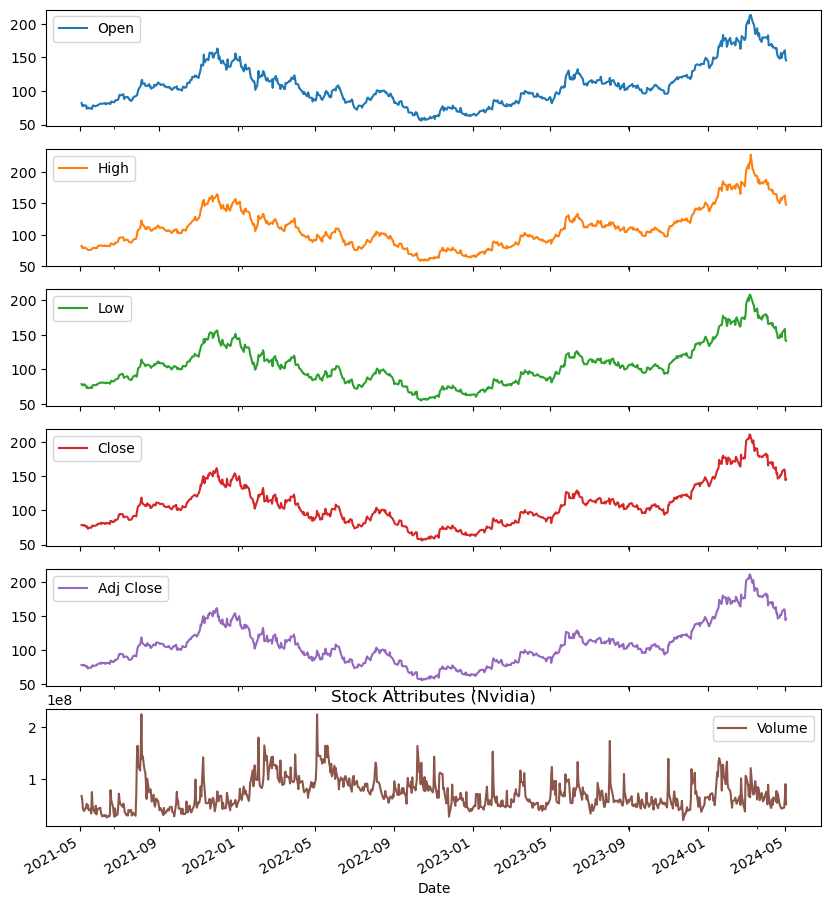

In [45]:
df_amd.plot(subplots = True, figsize=(10,12))
plt.title("Stock Attributes (Nvidia)")
plt.show()

In [46]:
fig = px.line(df_amd, y=['Open', 'Close', 'High', 'Low', 'Adj Close'], title = 'Date vs Stock Prices')
fig.show()

Judging the Closing price, AMD has been experiencing volatile rise and drop in its price.

AMD in October 2022 reached its lowest stock price on the chart due reporting a 40% decline in its client segment (PCs) that was almost the entire reason for AMD's shortfall when the PC makert came to a standstill in the second half of summer in 2022.

AMD in March 2024 experienced a high rise in stock price due to their announcement of their MI300 series AI chip for HPC and generative AI. Leading many investors heavily invest into the stock over the AI craze. But such rapid growth may be unsustainable due to the stronger position their competitors may have such as Nvidia and if the company fails to meet expectations may lead to significant damage to the stock.

The most recent drop can be explained with AMD's struggle to impress Wall Street with its earnings season, investors were not impressed even amid the rise in AI demand. Leading to a near 9% drop in stock price and affecting other company stocks such as Nvidia with a 3% stock drop. 

In [47]:
fig = px.line(df_amd, y=['Volume'], title = 'Date vs Stock Prices')
fig.show()

In [48]:
# AMD Candlestick Chart
# Further detailed chart evaluating noticeable drops and rises in data.

fig = go.Figure(data=[go.Candlestick(x=df_amd.index, open=df_amd['Open'], high=df_amd['High'], low=df_amd['Low'], close=df_amd['Close'])])

fig.update_layout(title='Nvidia Stock Price Candlestick Chart', xaxis_title='Date', yaxis_title='Stock Price (USD)')
fig.show()

### Calculation of Moving Average 

In [49]:
ma_day = [10,20,50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_amd[column_name] = df_amd['Adj Close'].rolling(ma).mean()

Text(0.5, 1.0, 'AMD Moving Averages')

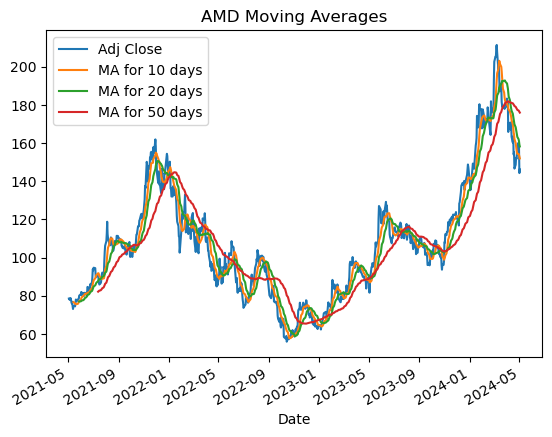

In [50]:
df_amd[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title("AMD Moving Averages")

Based on the graph, the moving average for 10 and 20 days are following the trend on a downward line. Signaling us that the stock is beginning to slope downwards after recent news regarding their earnings report. The drop in stock price is worse than the expected moving average for 50 days, showing that that it be a good time to invest into AMD before it can recover in the future.

Text(0.5, 1.0, 'AMD Daily Return')

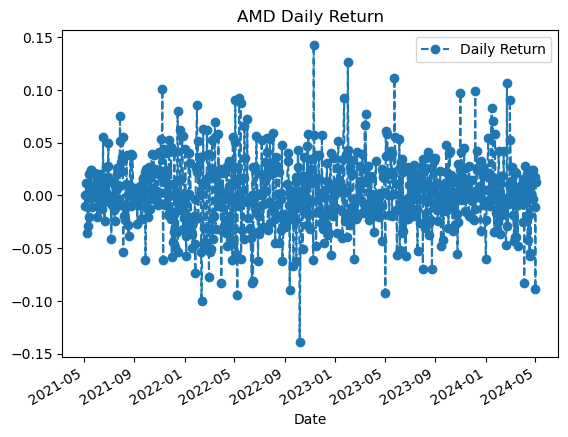

In [51]:
df_amd['Daily Return'] = df_amd['Adj Close'].pct_change()

df_amd['Daily Return'].plot(legend=True, linestyle='--', marker='o')
plt.title("AMD Daily Return")

Text(0.5, 1.0, 'AMD Daily Return')

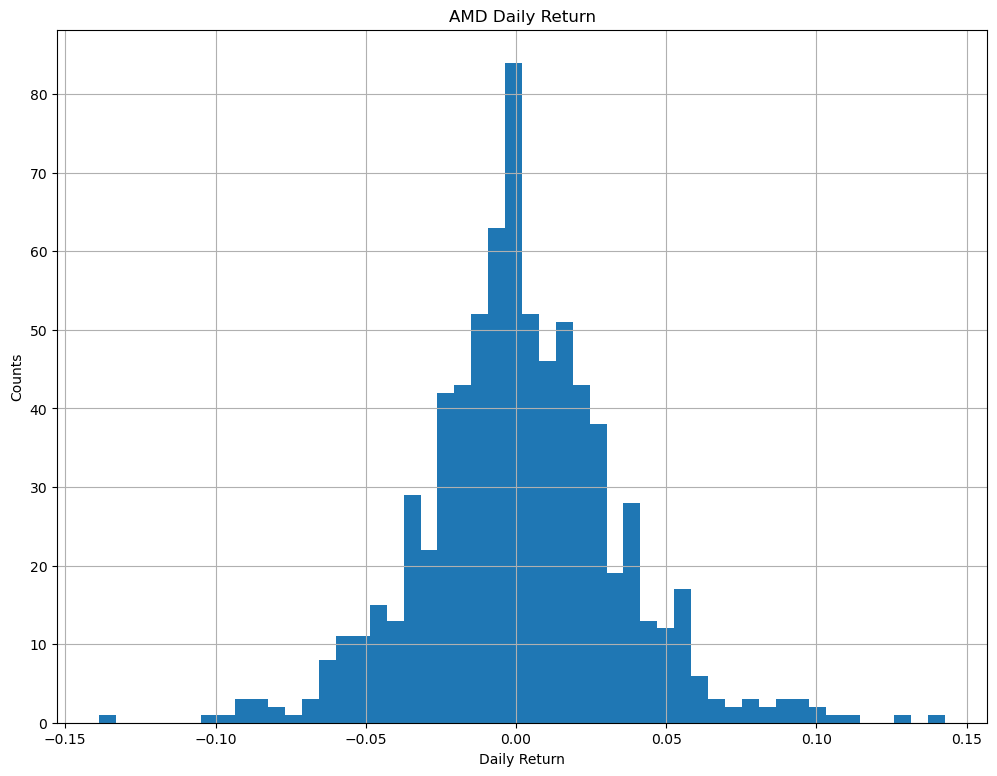

In [52]:
plt.figure(figsize=(12,9))

df_amd['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('AMD Daily Return')

Daily Return is the percentage of change in a stock's price from one trading day to the next. From what can be seen, the stock's price tends to fluctuate in a narrow range on a daily basis. Increasing and decreasing approximately 5%, forming a unimodal distribution.

In [53]:
closing_df = pdr.get_data_yahoo(stock, start=start, end=end)['Adj Close']
tech_rets = closing_df.pct_change()

[*********************100%%**********************]  1 of 1 completed


Text(50, 50, 'AMD')

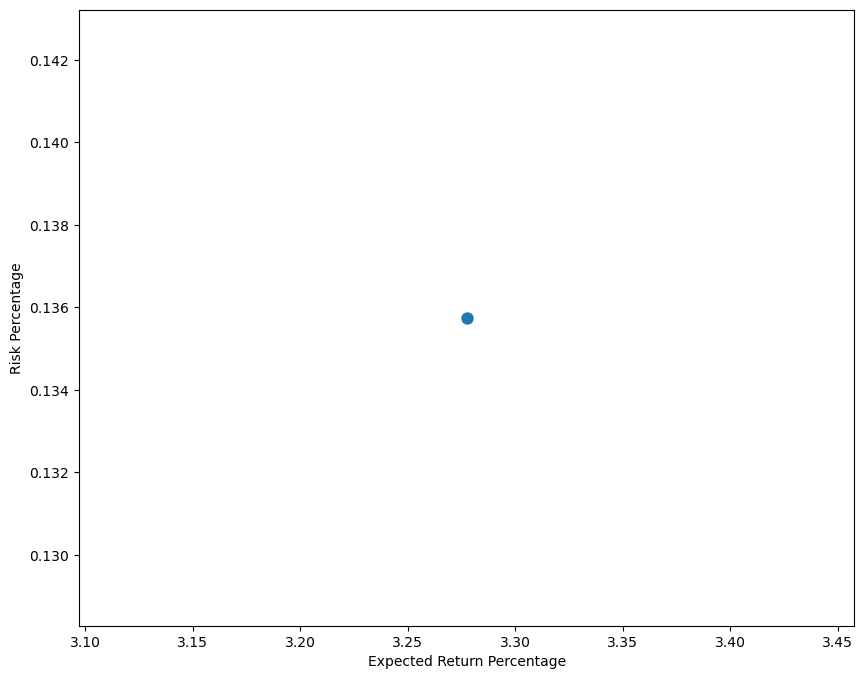

In [54]:
rets = tech_rets.dropna()

area = np.pi * 20

return_lvl = rets.mean()
return_lvl = return_lvl * 100

risk = rets.std()
risk = risk * 100

plt.figure(figsize=(10,8))
plt.scatter(risk, return_lvl, s=area)
plt.xlabel('Expected Return Percentage')
plt.ylabel('Risk Percentage')

plt.annotate(stock, xy=(rets.mean(), rets.std()), xytext=(50,50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue'))

Note: Best when using other stocks to compare with to show the level of risk and return from each stock but designed to show the idea of high risk and high reward.

## Prediction Model

In [55]:
start = datetime(end.year - 5, end.month, end.day)
df_amd = pdr.get_data_yahoo('AMD', start=start, end=end)
#getting larger dataset for research

[*********************100%%**********************]  1 of 1 completed


In [56]:
df_amd.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-03,28.299999,28.420000,27.660000,28.219999,28.219999,55503100
2019-05-06,26.719999,27.500000,26.450001,27.420000,27.420000,70344100
2019-05-07,27.200001,27.350000,26.209999,26.660000,26.660000,75868800
2019-05-08,26.410000,27.709999,26.270000,27.090000,27.090000,65967500
2019-05-09,26.700001,27.379999,26.030001,27.209999,27.209999,73150900


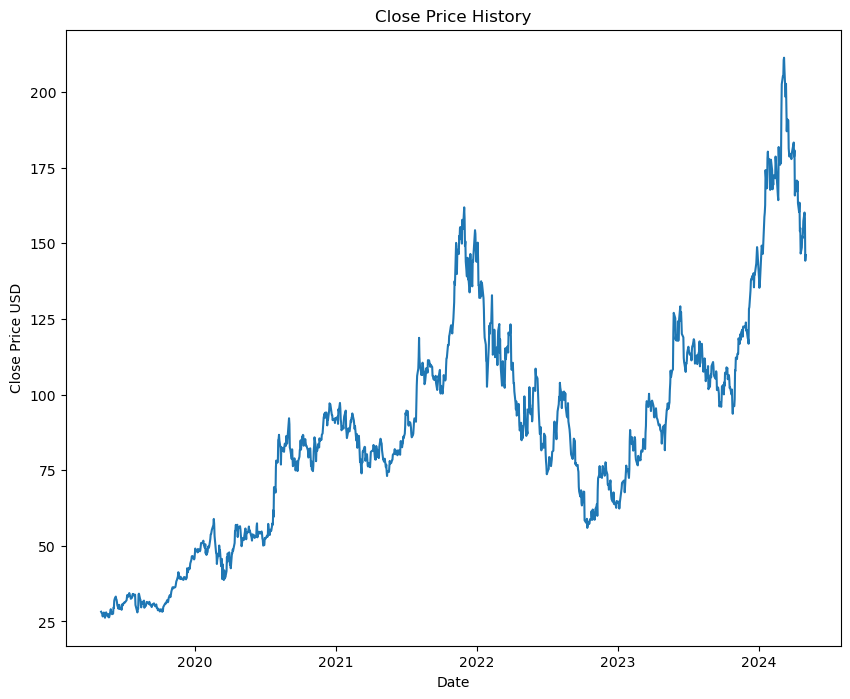

In [57]:
plt.figure(figsize=(10,8))
plt.title('Close Price History')
plt.plot(df_amd['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.show()

In [58]:
X = df_amd[['High', 'Low', 'Open']]  # Features
y = df_amd['Close']  # Target variable

# Create new dataframe with only 'Close' column
data = df_amd.filter(['Close'])
# convert dataframe to numpy array
dataset = data.values
# get number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95))

training_data_len

1197

In [59]:
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(dataset)

scaled_prices

array([[0.01069461],
       [0.00637356],
       [0.00226855],
       ...,
       [0.71373016],
       [0.63751756],
       [0.64772605]])

In [60]:
window_size = 60

# Create sequences
X, y = [], []
for i in range(len(scaled_prices) - window_size):
    X.append(scaled_prices[i:i+window_size])
    y.append(scaled_prices[i+window_size])

X, y = np.array(X), np.array(y)

In [61]:
# Define the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(window_size, 1)),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
30/30 [==============================] - 2s 24ms/step - loss: 0.0512 - val_loss: 0.0033
Epoch 2/100
30/30 [==============================] - 1s 19ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 3/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 4/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 5/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 7/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 8.7450e-04
Epoch 8/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 8.8792e-04
Epoch 9/100
30/30 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 8.3761e-04
Epoch 10/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0012 - val_

In [64]:
y_pred = model.predict(X_test)

8/8 [==============================] - 0s 6ms/step


In [65]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
loss = model.evaluate(X_test, y_test)

print('Test Loss:', loss)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared (R2) Score:', r2)


8/8 [==============================] - 0s 6ms/step - loss: 3.2642e-04
Test Loss: 0.0003264215192757547
Mean Squared Error: 0.0003264215886126825
Root Mean Squared Error: 0.018067141130037215
R-squared (R2) Score: 0.9905817500863222


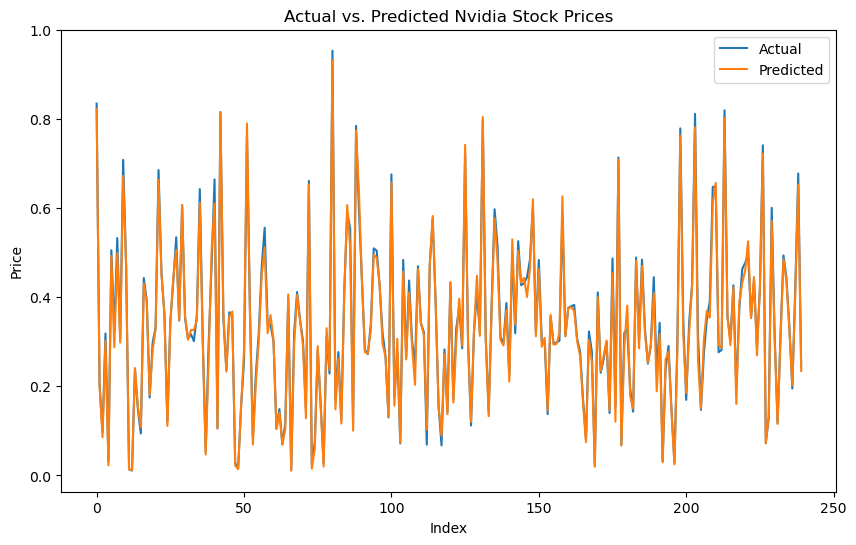

In [66]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Nvidia Stock Prices')
plt.legend()
plt.show()

In [67]:
# creating a new dataset to analyze within 60 days
test_data = scaled_prices[training_data_len - 60: , :]
test_set = []
for i in range(60, len(test_data)):
    test_set.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
test_set = np.array(test_set)

# Reshape the data
test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], 1 ))

In [68]:
prediction = model.predict(test_set)
scaled_pred = scaler.inverse_transform(prediction)

2/2 [==============================] - 0s 9ms/step


In [69]:
# Plot the data
valid = data[training_data_len:]
valid['Predictions'] = scaled_pred

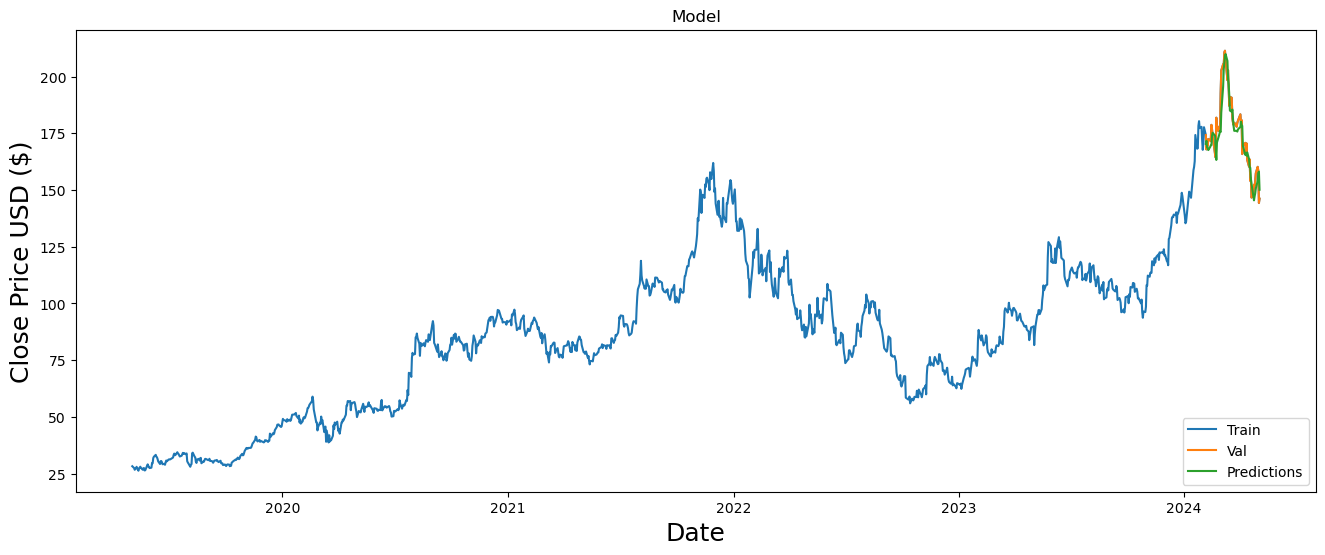

In [70]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_amd['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

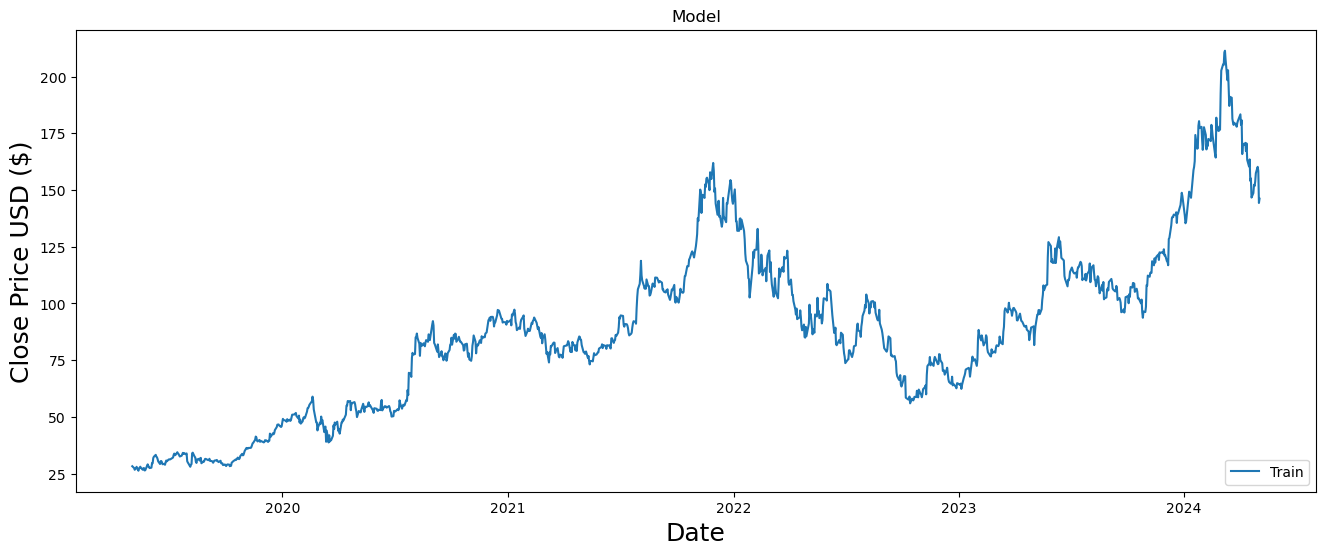

In [71]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_amd['Close'])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [72]:
valid

,Close,Predictions
Date,,
2024-02-05,174.229996,170.350769
2024-02-06,167.880005,171.670364
2024-02-07,170.940002,168.761887
2024-02-08,169.350006,168.445633
2024-02-09,172.479996,167.595306
...,...,...
2024-04-26,157.399994,150.709778
2024-04-29,160.199997,154.012619
2024-04-30,158.380005,157.403137


## Prediction

In [73]:
last_60_days = scaled_prices[-60:]

x_predict = np.reshape(last_60_days, (1,60,1))

predicted_value = model.predict(x_predict)

predicted_decimal = scaler.inverse_transform(predicted_value)

print("Predicted Decimal Value for the Next Day:", predicted_decimal[0][0])

1/1 [==============================] - 0s 27ms/step
Predicted Decimal Value for the Next Day: 145.573


In [74]:
future_days = 5

last_60_days = scaled_prices[-60:]

x_predict = np.reshape(last_60_days, (1,60,1))

predicted_values = []
for _ in range(future_days):
    # Predict the next day
    predicted_value = model.predict(x_predict)
    predicted_decimal = scaler.inverse_transform(predicted_value)
    
    # Store the predicted value
    predicted_values.append(predicted_decimal[0][0])
    
    # Shift the input data by one day for the next prediction
    x_predict = np.roll(x_predict, -1)
    x_predict[0, -1, 0] = predicted_value  # Replace the last value with the predicted value

print("Predicted Decimal Values for the Next", future_days, "Days:", predicted_values)

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step
Predicted Decimal Values for the Next 5 Days: [145.573, 142.95955, 140.60275, 138.48828, 136.61151]


From my results, there is reason to invest into AMD as a long-term investment. AMD's stock is facing a downward trend with its recent AI chip sales for 2024 falling short of expectations by Wall Street Investors compared to Nvidia beating its expectations.

Predictions from the model show the stock follow a downward trend for the next days following its drop in stock on May 1st. While it continues to drop, it will be an opportune time to invest into AMD's stock.

The AI trend will likely continue thanks to rapid development of AI which will fuel demand for semiconductor products. There is a high chance for AMD to rebound due to AI demand.